In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from math import nan
from CASutils import averaging_utils as avg

In [2]:
plotpath="/project/cas/islas/python_plots/singleforcing_paper/figures/supplemental/"

In [3]:
landfrac = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/ocn_wgts/LANDFRAC_LENS2.nc")

In [4]:
seas = 'am' ; var = ['FSNT','FSNS','FSDS','FSNTC']

In [5]:
# pre-processor to ensure all lon and lat coordinates are the same.  Also adding flexibility for reading in seasonal data
# Taking the ensemble mean
def preprocessor(ds):
    ds['lon'] = landfrac.lon ; ds['lat'] = landfrac.lat
    ds = ds.mean('M')
    ds = ds.sel(year=slice(1920,2050))
    return ds

### Read in CESM1 data

In [7]:
baselens1='/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS1/'
lens1 = []
for ivar in var:
    dat = xr.open_mfdataset(baselens1+'LENS1_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    lens1.append(dat)
lens1 = xr.merge(lens1)
fsus = lens1.FSDS - lens1.FSNS
fsus = fsus.rename('FSUS')
lens1 = xr.merge([lens1, fsus])

In [8]:
basexaer1="/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS1-SF/"
xaer1 = []
for ivar in var:
    dat = xr.open_mfdataset(basexaer1+'XAER_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    xaer1.append(dat)
xaer1 = xr.merge(xaer1)
fsus = xaer1.FSDS - xaer1.FSNS
fsus = fsus.rename('FSUS')
xaer1 = xr.merge([xaer1, fsus])

In [9]:
baseaer1="/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/CESM1-AAER/"
aer1 = []
for ivar in var:
    dat = xr.open_mfdataset(baseaer1+'AAER_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    aer1.append(dat)
aer1 = xr.merge(aer1)
fsus = aer1.FSDS - aer1.FSNS
fsus = fsus.rename('FSUS')
aer1 = xr.merge([aer1, fsus])

### Calculate the global mean

In [10]:
lens1_gm = avg.cosweightlonlat(lens1, 0, 360, -90, 90)
aer1_gm = avg.cosweightlonlat(aer1, 0, 360, -90, 90)
xaer1_gm = avg.cosweightlonlat(xaer1, 0, 360, -90, 90)

In [11]:
def calcglobalsum(darray, lon1, lon2, lat1, lat2):
    a = 6.37e6
    latrad = np.deg2rad(darray.lat)
    dphi = xr.DataArray(np.zeros([latrad.size]), coords=[darray.lat], dims=['lat'], name='dphi')
    dphimid = [ ((latrad.isel(lat=i+1).values - latrad.isel(lat=i).values)/2. + 
                (latrad.isel(lat=i).values - latrad.isel(lat=i-1).values)/2.) for i in np.arange(1,latrad.size-1,1) ]
    dphi[1:darray.lat.size-1] = dphimid
    dphi[0] = (latrad.isel(lat=1).values - latrad.isel(lat=0).values)/2. + (latrad.isel(lat=0).values - np.deg2rad(-90))
    dphi[darray.lat.size-1] = (latrad.isel(lat=latrad.size-1).values - latrad.isel(lat=latrad.size-2).values)/2. + \
                               np.deg2rad(90) - latrad.isel(lat=latrad.size-1).values
    lonrad = np.deg2rad(darray.lon)
    dlon = lonrad[1].values - lonrad[0].values

    cosphi = xr.DataArray(np.zeros([latrad.size]), coords=[darray.lat], dims=['lat'], name='cosphi')
    cosphi[:] = np.cos(np.deg2rad(darray.lat.values))
    
    weights = xr.DataArray(np.ones([latrad.size, lonrad.size]), coords=[darray.lat, darray.lon], dims=['lat','lon'], name='weights')
    weights = a**2 * weights*cosphi*dphi*dlon
    
    region = darray.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))
    weights = weights.sel(lon=slice(lon1, lon2), lat=slice(lat1,lat2))
    
    regionw = region.weighted(weights)
    integral = regionw.sum(("lon","lat"))
    
    return integral

In [12]:
lens1_int = calcglobalsum(lens1,0,360,-90,90)
aer1_int = calcglobalsum(aer1, 0, 360, -90, 90)
xaer1_int = calcglobalsum(xaer1, 0, 360, -90, 90)

lens1_int_50s50n = calcglobalsum(lens1, 0, 360, -50, 50)
aer1_int_50s50n = calcglobalsum(aer1, 0, 360, -50,50)
xaer1_int_50s50n = calcglobalsum(xaer1, 0, 360, -50,50)

lens1_int_50n90n = calcglobalsum(lens1, 0, 360, 50, 90)
aer1_int_50n90n = calcglobalsum(aer1, 0, 360, 50,90)
xaer1_int_50n90n = calcglobalsum(xaer1, 0, 360, 50,90)

lens1_int_50s90s = calcglobalsum(lens1, 0, 360, -90, -50)
aer1_int_50s90s = calcglobalsum(aer1, 0, 360, -90, -50)
xaer1_int_50s90s = calcglobalsum(xaer1, 0, 360, -90, -50)

### Subtract out the base period

In [13]:
lens1base = lens1_gm.sel(year=slice(1920,1940)).mean('year')
aer1base = aer1_gm.sel(year=slice(1920,1940)).mean('year')
xaer1base = xaer1_gm.sel(year=slice(1920,1940)).mean('year')

lens1_intbase = lens1_int.sel(year=slice(1920,1940)).mean('year')
aer1_intbase = aer1_int.sel(year=slice(1920,1940)).mean('year')
xaer1_intbase = xaer1_int.sel(year=slice(1920,1940)).mean('year')

lens1_50s50n_base = lens1_int_50s50n.sel(year=slice(1920,1940)).mean('year')
aer1_50s50n_base = aer1_int_50s50n.sel(year=slice(1920,1940)).mean('year')
xaer1_50s50n_base = xaer1_int_50s50n.sel(year=slice(1920,1940)).mean('year')

lens1_50n90n_base = lens1_int_50n90n.sel(year=slice(1920,1940)).mean('year')
aer1_50n90n_base = aer1_int_50n90n.sel(year=slice(1920,1940)).mean('year')
xaer1_50n90n_base = xaer1_int_50n90n.sel(year=slice(1920,1940)).mean('year')

lens1_50s90s_base = lens1_int_50s90s.sel(year=slice(1920,1940)).mean('year')
aer1_50s90s_base = aer1_int_50s90s.sel(year=slice(1920,1940)).mean('year')
xaer1_50s90s_base = xaer1_int_50s90s.sel(year=slice(1920,1940)).mean('year')

In [14]:
lens1anoms = lens1_gm - lens1base
aer1anoms = aer1_gm - aer1base
xaer1anoms = xaer1_gm - xaer1base

lens1anoms_int = lens1_int - lens1_intbase
aer1anoms_int = aer1_int - aer1_intbase
xaer1anoms_int = xaer1_int - xaer1_intbase

lens1anoms_int_50s50n = lens1_int_50s50n - lens1_50s50n_base
aer1anoms_int_50s50n = aer1_int_50s50n - aer1_50s50n_base
xaer1anoms_int_50s50n = xaer1_int_50s50n - xaer1_50s50n_base

lens1anoms_int_50n90n = lens1_int_50n90n - lens1_50n90n_base
aer1anoms_int_50n90n = aer1_int_50n90n - aer1_50n90n_base
xaer1anoms_int_50n90n = xaer1_int_50n90n - xaer1_50n90n_base

lens1anoms_int_50s90s = lens1_int_50s90s - lens1_50s90s_base
aer1anoms_int_50s90s = aer1_int_50s90s - aer1_50s90s_base
xaer1anoms_int_50s90s = xaer1_int_50s90s - xaer1_50s90s_base


In [15]:
aer1xwayanoms = lens1anoms - xaer1anoms
aer1xwayanoms_int = lens1anoms_int - xaer1anoms_int
aer1xwayanoms_int_50s50n = lens1anoms_int_50s50n - xaer1anoms_int_50s50n
aer1xwayanoms_int_50n90n = lens1anoms_int_50n90n - xaer1anoms_int_50n90n
aer1xwayanoms_int_50s90s = lens1anoms_int_50s90s - xaer1anoms_int_50s90s 

### Calculate the 21 year running mean

In [16]:
# 21 year running means
def calc21ymean(dat):
    datm = dat.rolling(year=21, min_periods=21, center='True').mean('year').dropna('year')
    return datm

In [17]:
aer1anoms_21y = calc21ymean(aer1anoms)
aer1xwayanoms_21y = calc21ymean(aer1xwayanoms)

aer1anoms_int_21y = calc21ymean(aer1anoms_int)
aer1xwayanoms_int_21y = calc21ymean(aer1xwayanoms_int)

aer1anoms_int_50s50n_21y = calc21ymean(aer1anoms_int_50s50n)
aer1xwayanoms_int_50s50n_21y = calc21ymean(aer1xwayanoms_int_50s50n)

aer1anoms_int_50n90n_21y = calc21ymean(aer1anoms_int_50n90n)
aer1xwayanoms_int_50n90n_21y = calc21ymean(aer1xwayanoms_int_50n90n)

aer1anoms_int_50s90s_21y = calc21ymean(aer1anoms_int_50s90s)
aer1xwayanoms_int_50s90s_21y = calc21ymean(aer1xwayanoms_int_50s90s)

In [18]:
aer1anoms_21y = aer1anoms_21y.load() ; aer1xwayanoms_21y = aer1xwayanoms_21y.load()
aer1anoms_int_21y = aer1anoms_int_21y.load() ; aer1xwayanoms_int_21y = aer1xwayanoms_int_21y.load()
aer1anoms_int_50s50n_21y = aer1anoms_int_50s50n_21y.load() ; aer1xwayanoms_int_50s50n_21y = aer1xwayanoms_int_50s50n_21y.load()
aer1anoms_int_50n90n_21y = aer1anoms_int_50n90n_21y.load() ; aer1xwayanoms_int_50n90n_21y = aer1xwayanoms_int_50n90n_21y.load()
aer1anoms_int_50s90s_21y = aer1anoms_int_50s90s_21y.load() ; aer1xwayanoms_int_50s90s_21y = aer1xwayanoms_int_50s90s_21y.load()

### Divide up into land and no land

In [19]:
### Set up weights
darray = landfrac
a = 6.371e6
latrad = np.deg2rad(darray.lat)
dphi = xr.DataArray(np.zeros([latrad.size]), coords=[darray.lat], dims=['lat'], name='dphi')
dphimid = [ ((latrad.isel(lat=i+1).values-latrad.isel(lat=i).values)/2. +  (latrad.isel(lat=i).values - latrad.isel(lat=i-1).values)/2.) 
        for i in np.arange(1,latrad.size-1,1)  ]
dphi[1:darray.lat.size-1] = dphimid
dphi[0] = (latrad.isel(lat=1).values - latrad.isel(lat=0).values)/2. + (latrad.isel(lat=0).values-(np.deg2rad(-90.)))
dphi[darray.lat.size-1] = (latrad.isel(lat=latrad.size-1).values - latrad.isel(lat=latrad.size-2).values)/2. + \
                               np.deg2rad(90) - latrad.isel(lat=latrad.size-1).values
lonrad = np.deg2rad(darray.lon)
dlon = lonrad[1].values - lonrad[0].values

cosphi = xr.DataArray(np.zeros([latrad.size]), coords=[darray.lat], dims=['lat'], name='cosphi')
cosphi[:] = np.cos(np.deg2rad(darray.lat.values))
    
weights = xr.DataArray(np.ones([latrad.size, lonrad.size]), coords=[darray.lat, darray.lon], dims=['lat','lon'], name='weights')
weights = a**2 * weights*cosphi*dphi*dlon

In [20]:
lens1base = lens1.sel(year=slice(1920,1940)).mean('year') ; lens1fsus = lens1.FSUS - lens1base.FSUS
aer1base = aer1.sel(year=slice(1920,1940)).mean('year') ; aer1fsus = aer1.FSUS - aer1base.FSUS
xaer1base = xaer1.sel(year=slice(1920,1940)).mean('year') ; xaer1fsus = xaer1.FSUS - xaer1base.FSUS
fsusdif = aer1fsus - (lens1fsus - xaer1fsus)
fsusdif = calc21ymean(fsusdif).load()

In [21]:
landfrac_stack = landfrac.landfrac.stack(z=("lon","lat"))
weights_stack = weights.stack(z=('lon','lat'))
fsusdif_stack = fsusdif.stack(z=('lon','lat'))

In [22]:
fsus_land = fsusdif_stack.where(landfrac_stack > 0.5, drop=True)
weights_land = weights_stack.where(landfrac_stack > 0.5, drop=True)

fsus_notland = fsusdif_stack.where(np.isnan(landfrac_stack) | (landfrac_stack <= 0.5), drop=True)
weights_notland = weights_stack.where(np.isnan(landfrac_stack) | (landfrac_stack <= 0.5), drop=True)

In [23]:
fsus_land_50n90n = fsus_land.where(fsus_land.lat > 50, drop=True)
weights_land_50n90n = weights_land.where(weights_land.lat > 50, drop=True)

fsus_notland_50n90n = fsus_notland.where(fsus_notland.lat > 50, drop=True)
weights_notland_50n90n = weights_notland.where(weights_notland.lat > 50, drop=True)

fsus_land_50s90s = fsus_land.where(fsus_land.lat < -50, drop=True)
weights_land_50s90s = weights_land.where(weights_land.lat < -50, drop=True)

fsus_notland_50s90s = fsus_notland.where(fsus_notland.lat < -50, drop=True)
weights_notland_50s90s = weights_notland.where(weights_notland.lat < -50, drop=True)

In [24]:
fsus_land_50n90n_w = fsus_land_50n90n.weighted(weights_land_50n90n)
fsus_land_50n90n_m = fsus_land_50n90n_w.sum("z")

fsus_notland_50n90n_w = fsus_notland_50n90n.weighted(weights_notland_50n90n)
fsus_notland_50n90n_m = fsus_notland_50n90n_w.sum("z")

fsus_land_50s90s_w = fsus_land_50s90s.weighted(weights_land_50s90s)
fsus_land_50s90s_m = fsus_land_50s90s_w.sum("z")

fsus_notland_50s90s_w = fsus_notland_50s90s.weighted(weights_notland_50s90s)
fsus_notland_50s90s_m = fsus_notland_50s90s_w.sum("z")

In [25]:
def setuppanel(x1, x2, y1, y2,titlestr):
    ax = fig.add_axes([x1, y1, x2-x1, y2-y1])
    ax.set_xlim(1930,2040)
    ax.set_xticks([1940,1960,1980,2000,2020,2040])
    ax.set_xticklabels(['1940','1960','1980','2000','2020','2040'], fontsize=14)
    ax.set_title(titlestr, fontsize=16)
    return ax

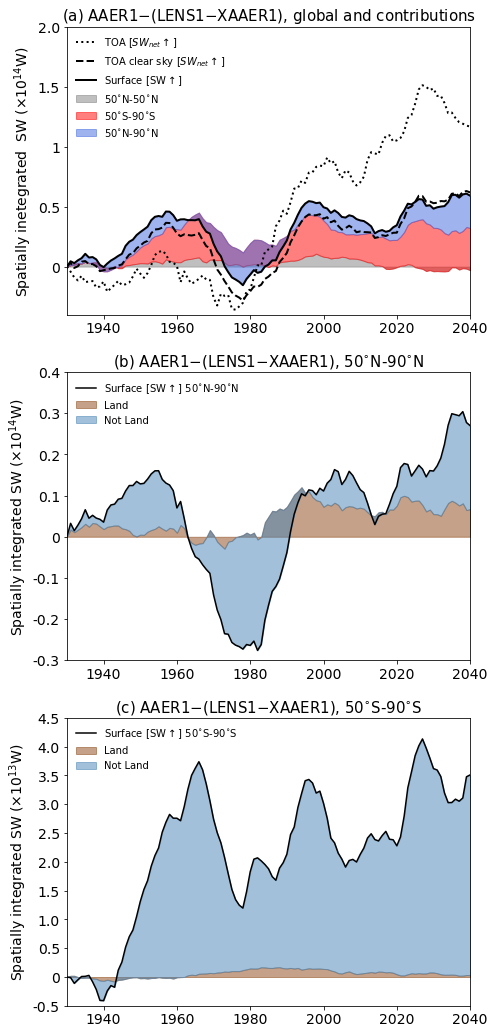

In [27]:
fig = plt.figure(figsize=(16,16))

methoddif = aer1anoms_int_21y - aer1xwayanoms_int_21y
methoddif_50s50n = aer1anoms_int_50s50n_21y - aer1xwayanoms_int_50s50n_21y
methoddif_50s90s = aer1anoms_int_50s90s_21y - aer1xwayanoms_int_50s90s_21y
methoddif_50n90n = aer1anoms_int_50n90n_21y - aer1xwayanoms_int_50n90n_21y

ax = setuppanel(0.05,0.4,0.75,1,' ')
ax.set_ylim(-0.4e14,2e14)
ax.set_yticks([0,0.5e14,1e14,1.5e14,2e14])
ax.set_yticklabels(['0','0.5','1','1.5','2.0'], fontsize=14)
ax.set_ylabel('Spatially inetegrated  SW ($\\times$10$^{14}$W)', fontsize=14)
ax.set_title('(a) AAER1$-$(LENS1$-$XAAER1), global and contributions', fontsize=15)
ax.plot(methoddif.year, -1.*methoddif.FSNT, linewidth=2, label='TOA $[SW_{net}\\uparrow$]', color='black', linestyle='dotted')
ax.plot(methoddif.year, -1.*methoddif.FSNTC, linewidth=2, label='TOA clear sky $[SW_{net}\\uparrow$]', color='black', linestyle='dashed') 
ax.plot(methoddif.year, methoddif.FSUS, linewidth=2, label='Surface [SW$\\uparrow$]', color='black')

ax.fill_between(methoddif_50s50n.year, 0, methoddif_50s50n.FSUS, color='gray', alpha=0.5, label='50$^{\circ}$N-50$^{\circ}$N')
sumcontrib = methoddif_50s50n.FSUS
ax.fill_between(methoddif_50s90s.year, sumcontrib, sumcontrib + methoddif_50s90s.FSUS, color='red', alpha=0.5, label='50$^{\circ}$S-90$^{\circ}$S')
sumcontrib = sumcontrib + methoddif_50s90s.FSUS
ax.fill_between(methoddif_50n90n.year, sumcontrib, sumcontrib + methoddif_50n90n.FSUS, color='royalblue', alpha=0.5, label='50$^{\circ}$N-90$^{\circ}$N')

leg = ax.legend()
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.)

ax = setuppanel(0.05,0.4,0.45,0.7,' ')
ax.set_ylim(-0.3e14, 0.4e14)
ax.set_yticks([-0.3e14,-0.2e14, -0.1e14, 0, 0.1e14, 0.2e14, 0.3e14, 0.4e14 ])
ax.set_yticklabels(['-0.3','-0.2','-0.1','0','0.1','0.2','0.3','0.4'], fontsize=14)
ax.set_ylabel('Spatially integrated SW ($\\times$10$^{14}$W)', fontsize=14)
ax.set_title('(b) AAER1$-$(LENS1$-$XAAER1), 50$^{\circ}$N-90$^{\circ}$N', fontsize=15)

ax.plot(methoddif_50n90n.year, methoddif_50n90n.FSUS, color='black', label='Surface [SW$\\uparrow$] 50$^{\circ}$N-90$^{\circ}$N')
ax.fill_between(fsus_land_50n90n_m.year, 0, fsus_land_50n90n_m, color='saddlebrown', alpha=0.5, label='Land')
ax.fill_between(fsus_land_50n90n_m.year, fsus_land_50n90n_m, fsus_land_50n90n_m + fsus_notland_50n90n_m, color='steelblue', alpha=0.5, label='Not Land')

leg = ax.legend()
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.)


ax = setuppanel(0.05,0.4,0.15,0.4,' ')
ax.set_ylim(-0.5e13,4.5e13)
ax.set_yticks([-0.5e13,0,0.5e13,1e13,1.5e13,2e13,2.5e13,3e13,3.5e13,4e13,4.5e13])
ax.set_yticklabels(['-0.5','0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5'], fontsize=14)
ax.set_ylabel('Spatially integrated SW ($\\times$10$^{13}$W)', fontsize=14)
ax.set_title('(c) AAER1$-$(LENS1$-$XAAER1), 50$^{\circ}$S-90$^{\circ}$S', fontsize=15)

ax.plot(methoddif_50s90s.year, methoddif_50s90s.FSUS, color='black', label='Surface [SW$\\uparrow$] 50$^{\circ}$S-90$^{\circ}$S')
ax.fill_between(fsus_land_50s90s_m.year, 0, fsus_land_50s90s_m, color='saddlebrown', alpha=0.5, label='Land')
ax.fill_between(fsus_land_50s90s_m.year, fsus_land_50s90s_m, fsus_land_50s90s_m + fsus_notland_50s90s_m, color='steelblue', alpha=0.5, label='Not Land')

leg = ax.legend(loc='upper left')
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.)



fig.savefig(plotpath+'figS11.pdf', bbox_inches='tight', facecolor='white')
fig.savefig(plotpath+'figS11.png', bbox_inches='tight', facecolor='white')